In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
data_path = '/kaggle/input/telecom-customer-churn-insights-for-analysis/customer_churn_data.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset and its shape
print(df.head())
print("Shape of the dataset:", df.shape)

   CustomerID  Age  Gender  Tenure  MonthlyCharges    ContractType  \
0           1   49    Male       4           88.35  Month-to-Month   
1           2   43    Male       0           36.67  Month-to-Month   
2           3   51  Female       2           63.79  Month-to-Month   
3           4   60  Female       8          102.34        One-Year   
4           5   42    Male      32           69.01  Month-to-Month   

  InternetService  TotalCharges TechSupport Churn  
0     Fiber Optic        353.40         Yes   Yes  
1     Fiber Optic          0.00         Yes   Yes  
2     Fiber Optic        127.58          No   Yes  
3             DSL        818.72         Yes   Yes  
4             NaN       2208.32          No   Yes  
Shape of the dataset: (1000, 10)


In [2]:
# Detect missing values
print("Missing values per column:")
print(df.isnull().sum())


Missing values per column:
CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64


In [3]:
df = df.drop_duplicates()


In [4]:
for column in df.select_dtypes(include=['object']).columns:
    mode_value = df[column].mode()[0]  # Find the mode
    df[column] = df[column].fillna(mode_value)  # Assign back to the column
# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
CustomerID         0
Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64


In [5]:
# Function to detect outliers for all numerical columns
def detect_outliers_all_columns(df):
    numerical_columns = df.select_dtypes(include=['float', 'int']).columns
    outliers_summary = {}

    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)  # 25th percentile
        Q3 = df[column].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile range

        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
        outliers_summary[column] = outliers_count

    return outliers_summary

# Detect outliers in all numerical columns
outliers_summary = detect_outliers_all_columns(df)
print("Outliers detected in each column:")
print(outliers_summary)


Outliers detected in each column:
{'CustomerID': 0, 'Age': 8, 'Tenure': 61, 'MonthlyCharges': 0, 'TotalCharges': 57}


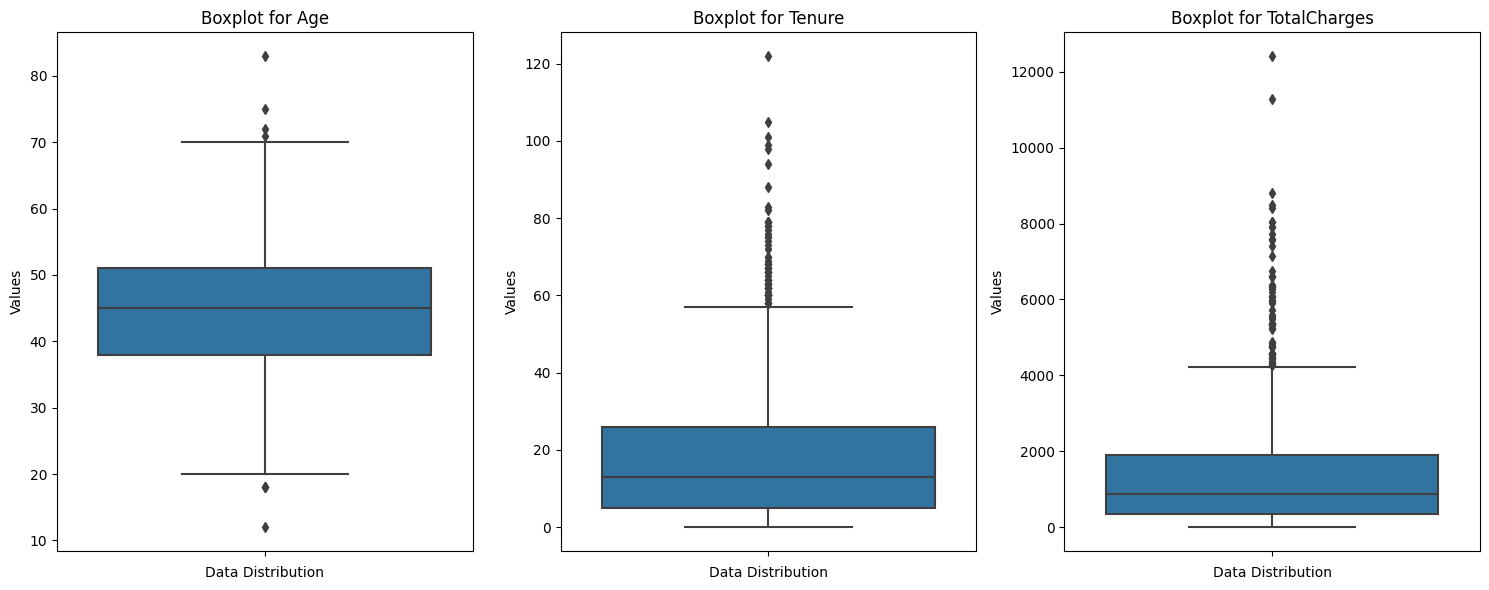

In [6]:
# Visualize columns with outliers using subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of columns with outliers
columns_with_outliers = [column for column, count in outliers_summary.items() if count > 0]

# Define the number of subplots
num_columns = len(columns_with_outliers)
fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 6), sharey=False)

# Create a boxplot for each column
for i, column in enumerate(columns_with_outliers):
    sns.boxplot(data=df, y=column, ax=axes[i])
    axes[i].set_title(f"Boxplot for {column}")
    axes[i].set_xlabel("Data Distribution")
    axes[i].set_ylabel("Values")

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [7]:
print(df.dtypes)

CustomerID           int64
Age                  int64
Gender              object
Tenure               int64
MonthlyCharges     float64
ContractType        object
InternetService     object
TotalCharges       float64
TechSupport         object
Churn               object
dtype: object


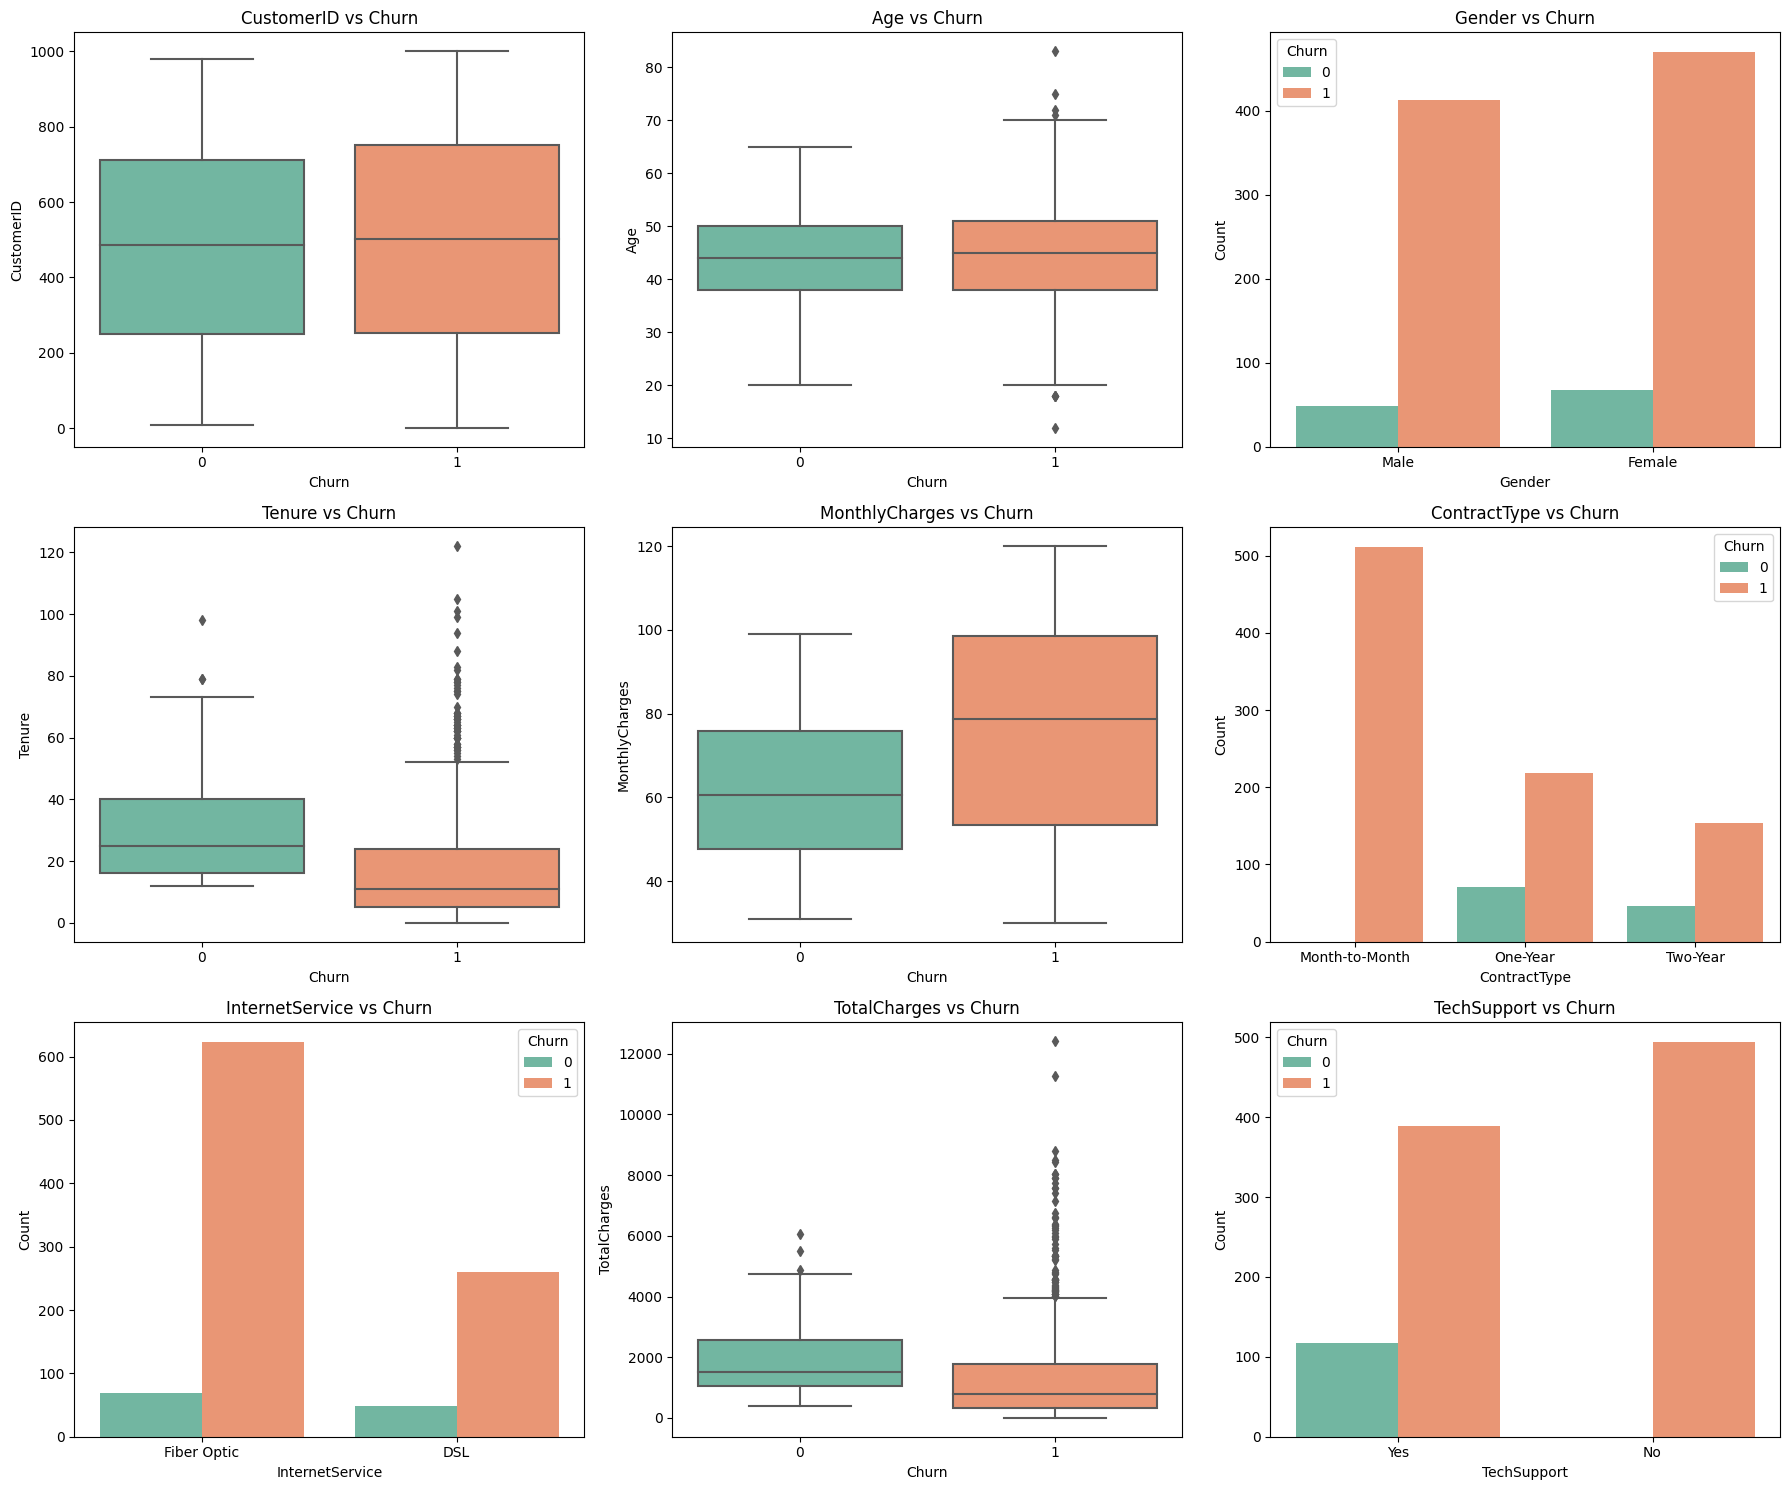

In [8]:
# Separate the target variable
target = df['Churn']

# Convert 'Churn' to numeric if it's not already
if target.dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features
features = df.drop(columns=['Churn'])

# Set up the canvas for subplots
num_features = len(features.columns)
cols = 3  # Number of columns in the grid
rows = int(np.ceil(num_features / cols))  # Number of rows based on the number of features

plt.figure(figsize=(18, rows * 5))  # Adjust the canvas size as needed

# Loop through each feature and create subplots
for i, column in enumerate(features.columns, 1):
    plt.subplot(rows, cols, i)
    
    # Check the type of feature: numeric or categorical
    if features[column].dtype in ['int64', 'float64']:
        sns.boxplot(data=df, x='Churn', y=column, palette='Set2')
        plt.ylabel(column)
        plt.xlabel('Churn')
    else:
        sns.countplot(data=df, x=column, hue='Churn', palette='Set2')
        plt.xlabel(column)
        plt.ylabel('Count')
    
    plt.title(f'{column} vs Churn')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [9]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Function to convert columns in the DataFrame to numeric
def convert_to_numeric(df):
    for column in df.columns:
        # Convert object (categorical) columns to numeric using Label Encoding
        if df[column].dtype == 'object':
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column].astype(str))  # Ensure all entries are strings before encoding
        # Convert datetime columns to numerical (days since the first date)
        elif df[column].dtype == 'datetime64[ns]':
            df[column] = (df[column] - df[column].min()) / np.timedelta64(1, 'D')
        # Convert boolean columns to integers
        elif df[column].dtype == 'bool':
            df[column] = df[column].astype(int)
    return df

# Apply the conversion function directly to df
convert_to_numeric(df)

# Ensure all columns are numeric
print(df.dtypes)

# Display the first few rows of the modified DataFrame
print(df.head())


CustomerID           int64
Age                  int64
Gender               int64
Tenure               int64
MonthlyCharges     float64
ContractType         int64
InternetService      int64
TotalCharges       float64
TechSupport          int64
Churn                int64
dtype: object
   CustomerID  Age  Gender  Tenure  MonthlyCharges  ContractType  \
0           1   49       1       4           88.35             0   
1           2   43       1       0           36.67             0   
2           3   51       0       2           63.79             0   
3           4   60       0       8          102.34             1   
4           5   42       1      32           69.01             0   

   InternetService  TotalCharges  TechSupport  Churn  
0                1        353.40            1      1  
1                1          0.00            1      1  
2                1        127.58            0      1  
3                0        818.72            1      1  
4                1       2208.32

In [10]:
print(df.dtypes)

CustomerID           int64
Age                  int64
Gender               int64
Tenure               int64
MonthlyCharges     float64
ContractType         int64
InternetService      int64
TotalCharges       float64
TechSupport          int64
Churn                int64
dtype: object


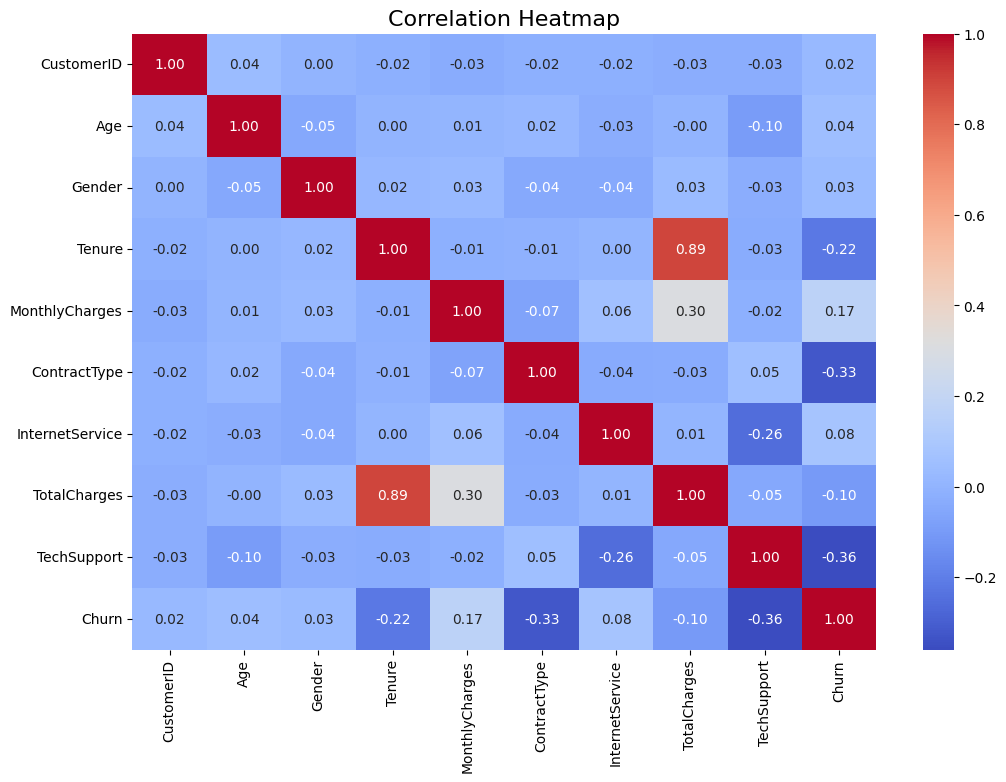

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the figure
plt.figure(figsize=(12, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Add title
plt.title('Correlation Heatmap', fontsize=16)

# Display the plot
plt.show()


In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Log Transformation for Skewed Columns (e.g., TotalCharges, MonthlyCharges)
skewed_columns = ['TotalCharges', 'MonthlyCharges']  # Replace with actual skewed columns in your data
for column in skewed_columns:
    df[column] = df[column].apply(lambda x: np.log1p(x) if x > 0 else 0)

# 2. Feature Scaling
scaler = StandardScaler()
numeric_features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']  # Replace with your numeric columns
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# 3. Feature Creation: Average Charge Per Month
df['AvgChargePerMonth'] = df['TotalCharges'] / (df['Tenure'] + 1)  # Avoid division by zero

# 4. Drop Redundant Features
# Drop 'CustomerID' (as it's not useful for prediction)
df = df.drop(columns=['CustomerID'])

# 5. Check the updated DataFrame
print(df.head())


        Age  Gender    Tenure  MonthlyCharges  ContractType  InternetService  \
0  0.441751       1 -0.792930        0.629255             0                1   
1 -0.170941       1 -1.004760       -1.682206             0                1   
2  0.645982       0 -0.898845       -0.230915             0                1   
3  1.565021       0 -0.581101        1.018550             1                0   
4 -0.273057       1  0.689875       -0.023542             0                1   

   TotalCharges  TechSupport  Churn  AvgChargePerMonth  
0     -0.286460            1      1          -1.383401  
1     -3.440125            1      1         722.755364  
2     -0.831126            0      1          -8.216368  
3      0.164012            1      1           0.391530  
4      0.696645            0      1           0.412247  


In [13]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df.drop(columns=['Churn'])  # Replace 'Churn' with your target column
y = df['Churn']

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the sizes of the resulting datasets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (800, 9)
Test set size: (200, 9)


In [14]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Initialize models
models = {
     "KNN": KNeighborsClassifier(n_neighbors=5),
        
     "NeuralNetwork": MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
   "XGB": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)

   
}

# Train and evaluate models
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Append results to the list
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Add VotingClassifier as an ensemble model
voting_clf = VotingClassifier(estimators=[
    ("LogisticRegression", models["LogisticRegression"]),
    ("KNN", models["KNN"]),
    ("DecisionTree", models["DecisionTree"]),
    ("RandomForest", models["RandomForest"]),
    ("XGB", models["XGB"])
], voting='soft')
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# Evaluate Voting Classifier
accuracy = accuracy_score(y_test, y_pred_voting)
precision = precision_score(y_test, y_pred_voting)
recall = recall_score(y_test, y_pred_voting)
f1 = f1_score(y_test, y_pred_voting)

# Append VotingClassifier results
results.append({
    "Model": "VotingClassifier",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by F1-Score (or another metric of choice)
results_df = results_df.sort_values(by="F1-Score", ascending=False, ignore_index=True)

# Print the results
print(results_df)

# Identify the best model
best_model = results_df.iloc[0]
print("\nBest Model:")
print(best_model)


                Model  Accuracy  Precision   Recall  F1-Score
0       NeuralNetwork     1.000   1.000000  1.00000  1.000000
1                 XGB     1.000   1.000000  1.00000  1.000000
2        DecisionTree     1.000   1.000000  1.00000  1.000000
3        RandomForest     1.000   1.000000  1.00000  1.000000
4    VotingClassifier     1.000   1.000000  1.00000  1.000000
5                 KNN     0.975   0.977778  0.99435  0.985994
6  LogisticRegression     0.955   0.951613  1.00000  0.975207

Best Model:
Model        NeuralNetwork
Accuracy               1.0
Precision              1.0
Recall                 1.0
F1-Score               1.0
Name: 0, dtype: object


In [15]:
from sklearn.model_selection import cross_val_score

# Example with Random Forest
rf_scores = cross_val_score(RandomForestClassifier(), X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {rf_scores.mean():.4f}")


Cross-Validation Accuracy: 0.9980


In [16]:
# Random Forest feature importance
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)


             Feature  Importance
4       ContractType    0.253103
7        TechSupport    0.237934
2             Tenure    0.173132
3     MonthlyCharges    0.138155
8  AvgChargePerMonth    0.086206
6       TotalCharges    0.085649
0                Age    0.017231
5    InternetService    0.005231
1             Gender    0.003358


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluates a given model on the test set and returns performance metrics.

    Parameters:
    - model: Trained model to evaluate
    - X_test: Test set features
    - y_test: Test set target labels

    Returns:
    - Dictionary containing evaluation metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Check if the model has probability estimates for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None  # Not all models provide probabilities

    # Return results as a dictionary
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

# Evaluate all models
evaluation_results = []

for name, model in models.items():
    metrics = evaluate_model(model, X_test, y_test)
    metrics["Model"] = name  # Add model name for identification
    evaluation_results.append(metrics)

# Evaluate VotingClassifier
voting_metrics = evaluate_model(voting_clf, X_test, y_test)
voting_metrics["Model"] = "VotingClassifier"
evaluation_results.append(voting_metrics)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(evaluation_results)

# Sort by F1-Score or another metric of choice
results_df = results_df.sort_values(by="F1-Score", ascending=False, ignore_index=True)

# Display evaluation results
print(results_df)


   Accuracy  Precision   Recall  F1-Score   ROC-AUC               Model
0     1.000   1.000000  1.00000  1.000000  1.000000       NeuralNetwork
1     1.000   1.000000  1.00000  1.000000  1.000000                 XGB
2     1.000   1.000000  1.00000  1.000000  1.000000        DecisionTree
3     1.000   1.000000  1.00000  1.000000  1.000000        RandomForest
4     1.000   1.000000  1.00000  1.000000  1.000000    VotingClassifier
5     0.975   0.977778  0.99435  0.985994  0.990789                 KNN
6     0.955   0.951613  1.00000  0.975207  0.991157  LogisticRegression


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.preprocessing import StandardScaler

# Scale the data to address potential convergence issues with NeuralNetwork
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grids
param_grids = {
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGB": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "NeuralNetwork": {
        "hidden_layer_sizes": [(32,), (64, 32), (32, 16)],
        "activation": ["relu", "tanh"],
        "solver": ["adam", "sgd"],
        "learning_rate_init": [0.001, 0.01, 0.1],
        "max_iter": [1000]  # Increase max_iter to allow more iterations
    }
}

# Create a custom scorer (F1-score)
f1_scorer = make_scorer(f1_score, average='binary')

# Hyperparameter tuning on training data
best_models_train = {}

for model_name, param_grid in param_grids.items():
    print(f"Tuning {model_name} on training data...")
    model = models[model_name]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    if model_name == "NeuralNetwork":
        grid_search.fit(X_train_scaled, y_train)  # Use scaled data for NeuralNetwork
    else:
        grid_search.fit(X_train, y_train)
    
    # Store the best model and parameters
    best_models_train[model_name] = {
        "best_estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

# Evaluate the tuned models on training data
tuned_results_train = []
for model_name, best_model_info in best_models_train.items():
    best_model = best_model_info["best_estimator"]
    if model_name == "NeuralNetwork":
        y_pred = best_model.predict(X_train_scaled)  # Use scaled data for NeuralNetwork
    else:
        y_pred = best_model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)
    tuned_results_train.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert training results to DataFrame
tuned_results_train_df = pd.DataFrame(tuned_results_train)

# Sort by F1-Score
tuned_results_train_df = tuned_results_train_df.sort_values(by="F1-Score", ascending=False, ignore_index=True)

# Print the training results
print("Results on Training Data:")
print(tuned_results_train_df)

# Hyperparameter tuning on test data
best_models_test = {}

for model_name, param_grid in param_grids.items():
    print(f"Tuning {model_name} on test data...")
    model = models[model_name]
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    if model_name == "NeuralNetwork":
        grid_search.fit(X_test_scaled, y_test)  # Use scaled data for NeuralNetwork
    else:
        grid_search.fit(X_test, y_test)
    
    # Store the best model and parameters
    best_models_test[model_name] = {
        "best_estimator": grid_search.best_estimator_,
        "best_params": grid_search.best_params_,
        "best_score": grid_search.best_score_
    }

# Evaluate the tuned models on test data
tuned_results_test = []
for model_name, best_model_info in best_models_test.items():
    best_model = best_model_info["best_estimator"]
    if model_name == "NeuralNetwork":
        y_pred = best_model.predict(X_test_scaled)  # Use scaled data for NeuralNetwork
    else:
        y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tuned_results_test.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

# Convert test results to DataFrame
tuned_results_test_df = pd.DataFrame(tuned_results_test)

# Sort by F1-Score
tuned_results_test_df = tuned_results_test_df.sort_values(by="F1-Score", ascending=False, ignore_index=True)

# Print the test results
print("Results on Test Data:")
print(tuned_results_test_df)

# Identify the best tuned model on training data
best_tuned_model_train = tuned_results_train_df.iloc[0]
print("\nBest Tuned Model on Training Data:")
print(best_tuned_model_train)

# Identify the best tuned model on test data
best_tuned_model_test = tuned_results_test_df.iloc[0]
print("\nBest Tuned Model on Test Data:")
print(best_tuned_model_test)


Tuning RandomForest on training data...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tuning XGB on training data...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tuning NeuralNetwork on training data...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Results on Training Data:
           Model  Accuracy  Precision  Recall  F1-Score
0   RandomForest    1.0000   1.000000     1.0  1.000000
1            XGB    1.0000   1.000000     1.0  1.000000
2  NeuralNetwork    0.9875   0.986034     1.0  0.992968
Tuning RandomForest on test data...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tuning XGB on test data...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tuning NeuralNetwork on test data...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perce

Results on Test Data:
           Model  Accuracy  Precision   Recall  F1-Score
0   RandomForest     1.000        1.0  1.00000  1.000000
1  NeuralNetwork     1.000        1.0  1.00000  1.000000
2            XGB     0.995        1.0  0.99435  0.997167

Best Tuned Model on Training Data:
Model        RandomForest
Accuracy              1.0
Precision             1.0
Recall                1.0
F1-Score              1.0
Name: 0, dtype: object

Best Tuned Model on Test Data:
Model        RandomForest
Accuracy              1.0
Precision             1.0
Recall                1.0
F1-Score              1.0
Name: 0, dtype: object


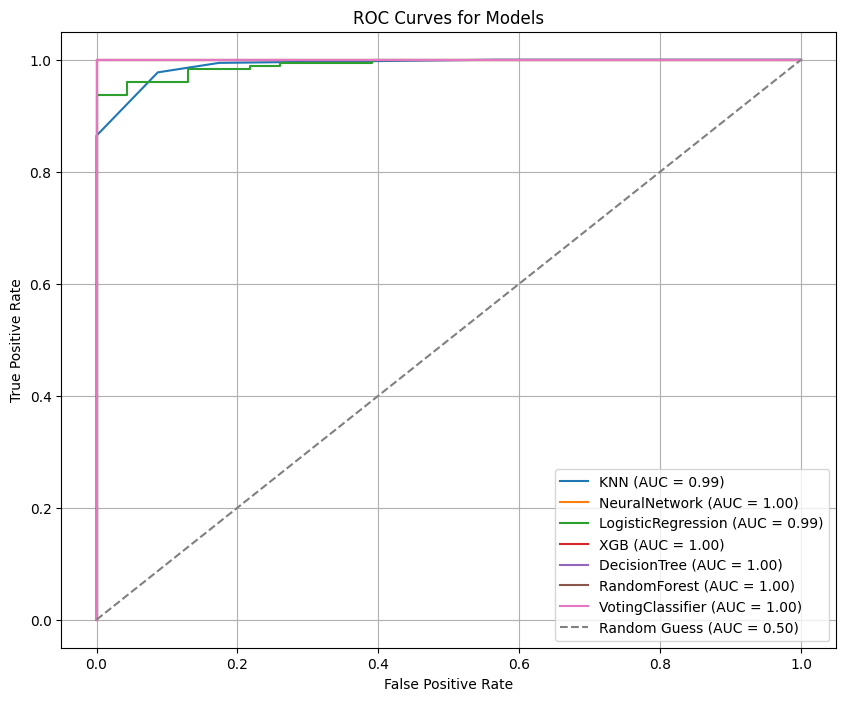

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(models, X_test, y_test):
    """
    Plots ROC curves for multiple models.

    Parameters:
    - models: Dictionary of trained models with their names as keys
    - X_test: Test set features
    - y_test: Test set target labels
    """
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        # Check if the model has predict_proba
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)  # Use decision_function for SVMs
        else:
            continue  # Skip models that don't provide probabilities or decision scores
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    # Plot the diagonal (random guess)
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess (AUC = 0.50)")
    
    plt.title("ROC Curves for Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Add VotingClassifier to the models dictionary for evaluation
models["VotingClassifier"] = voting_clf

# Plot ROC curves for all models
plot_roc_curves(models, X_test, y_test)
